# DEMAND FORECASTING OF BIKE RENTAL DATA

## MODEL CREATION

### IMPORTS

In [1]:
import os
import sys
python_executable = sys.executable
os.environ["PYSPARK_PYTHON"] = python_executable
os.environ["PYSPARK_DRIVER_PYTHON"] = python_executable
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, year, count, date_trunc, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mlflow
import mlflow.spark


### INITIALIZE SPARK SESSION

In [2]:
spark = SparkSession.builder \
    .appName("DemandForecasting") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

### DATASET CREATION - DATA FROM 2023 January to 2024 September merged

In [3]:
data_path = "D:/BDA_MINI_PROJECT/CITYBIKE_data"
data_files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith(".csv")]

merged_df = None
for file in data_files:
    current_df = spark.read.csv(file, header=True, inferSchema=True)
    if merged_df is None:
        merged_df = current_df
    else:
        merged_df = merged_df.union(current_df)

In [4]:
merged_df.printSchema()
merged_df.show()
row_count = merged_df.count()
print(f"Number of rows in the DataFrame: {row_count}")

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+------------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|      

### DATA PREPROCESSING

#### DATA FORMATTING

In [5]:
# Casting timestamps and handling missing values
merged_df = merged_df.withColumn("started_at", col("started_at").cast("timestamp")) \
                     .withColumn("ended_at", col("ended_at").cast("timestamp"))

# Dropping rows with nulls in important columns
merged_df = merged_df.dropna(subset=["ride_id", "started_at", "ended_at"])

# Create time-related features (hour, dayofweek, month, year)
merged_df = merged_df.withColumn("hour", hour(col("started_at"))) \
                     .withColumn("dayofweek", dayofweek(col("started_at"))) \
                     .withColumn("month", month(col("started_at"))) \
                     .withColumn("year", year(col("started_at")))

#### DATA AGGREGATION

In [6]:
# Aggregate the data to get the number of rides per day
df_daily = merged_df.groupBy(date_trunc("day", col("started_at")).alias("date")) \
                    .agg(count("ride_id").alias("num_rides"))

# Add dayofweek, month, and year to the aggregated data for the model
df_daily = df_daily.withColumn("dayofweek", dayofweek(col("date"))) \
                   .withColumn("month", month(col("date"))) \
                   .withColumn("year", year(col("date")))

#### DATA VISUALIZATION


Plotting the trend of rides over time


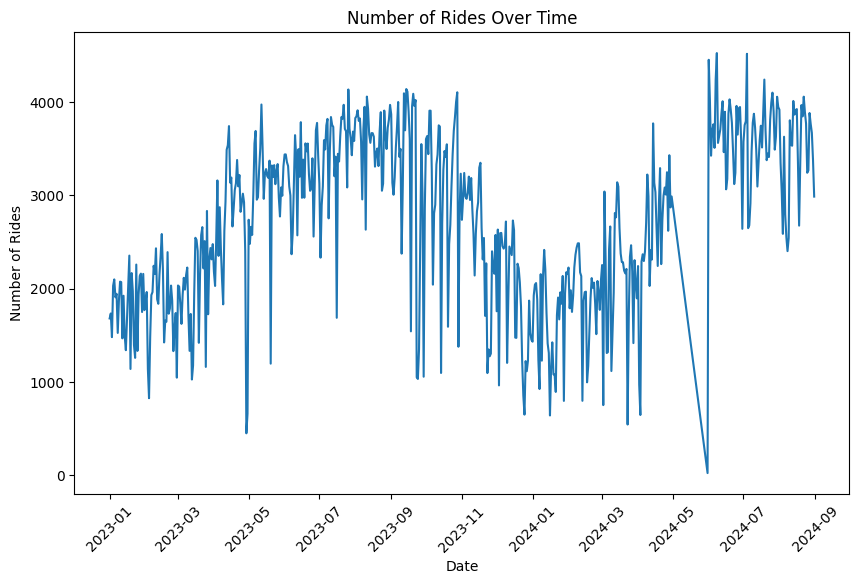

In [8]:
pandas_df = df_daily.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="num_rides", data=pandas_df)
plt.title("Number of Rides Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)
plt.show()

Boxplot for number of rides by day of the week


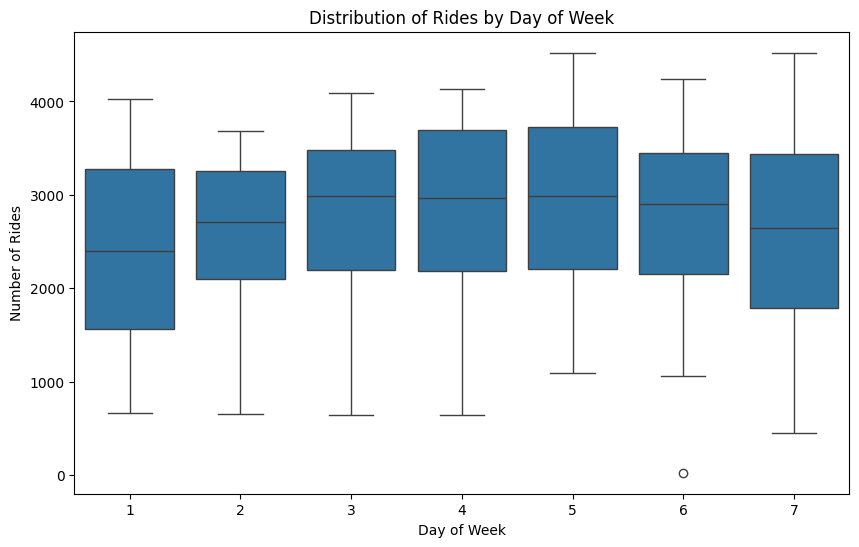

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="dayofweek", y="num_rides", data=pandas_df)
plt.title("Distribution of Rides by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.show()

Correlation Heatmap

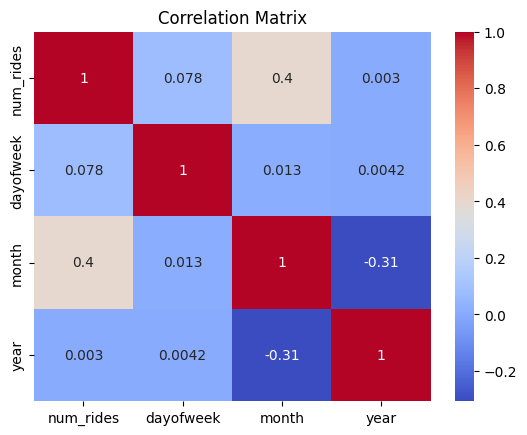

In [10]:
corr_matrix = np.array(df_daily.select("num_rides", "dayofweek", "month", "year").toPandas().corr())
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", xticklabels=["num_rides", "dayofweek", "month", "year"],
            yticklabels=["num_rides", "dayofweek", "month", "year"])
plt.title("Correlation Matrix")
plt.show()

Weekly Trend of Rides (Average number of rides per day of the week)


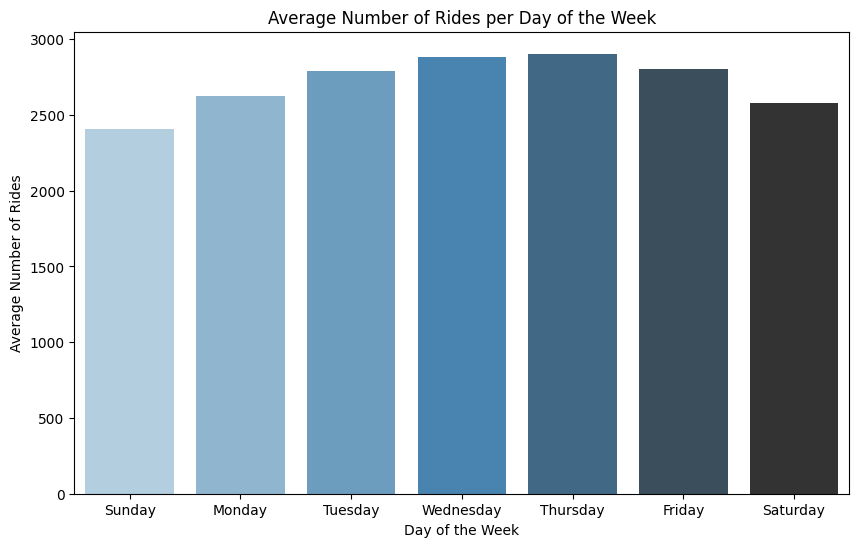

In [11]:
weekly_trend = df_daily.groupBy("dayofweek").agg({"num_rides": "avg"}).orderBy("dayofweek")
weekly_trend_pandas = weekly_trend.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="dayofweek", y="avg(num_rides)", hue="dayofweek", data=weekly_trend_pandas, palette="Blues_d", dodge=False, legend=False)
plt.title("Average Number of Rides per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Number of Rides")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
plt.show()

Monthly Trend of Rides (Average number of rides per month)

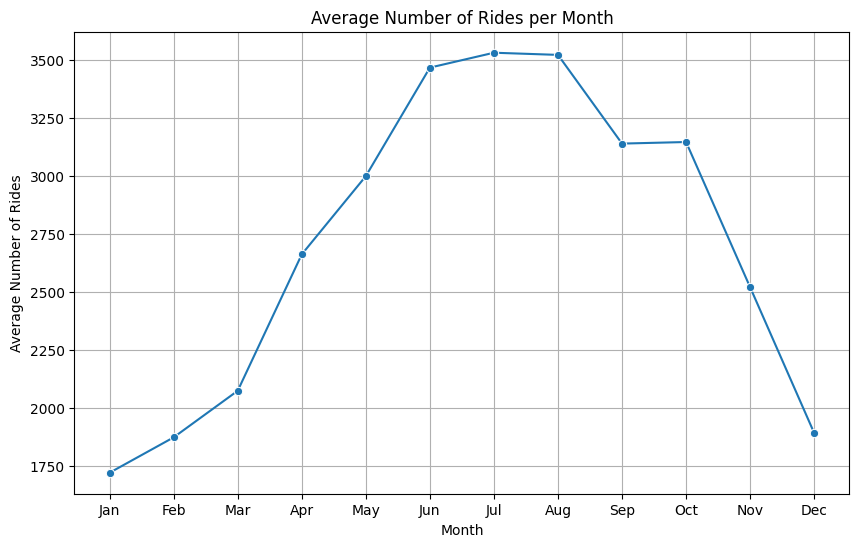

In [12]:
monthly_trend = df_daily.groupBy("month").agg({"num_rides": "avg"}).orderBy("month")
monthly_trend_pandas = monthly_trend.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="month", y="avg(num_rides)", data=monthly_trend_pandas, marker='o')
plt.title("Average Number of Rides per Month")
plt.xlabel("Month")
plt.ylabel("Average Number of Rides")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.show()

#### OUTLIER DETECTION AND REMOVAL

In [13]:
percentile_99 = pandas_df["num_rides"].quantile(0.99)
df_daily = df_daily.withColumn(
    "num_rides",
    when(col("num_rides") > percentile_99, percentile_99).otherwise(col("num_rides"))
)

#### FEATURE SCALING

In [14]:
assembler = VectorAssembler(inputCols=["dayofweek", "month", "year"], outputCol="raw_features")
df_daily = assembler.transform(df_daily)

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_daily)
df_daily = scaler_model.transform(df_daily)

#### TRAIN-TEST SPLIT

In [15]:
train_data = df_daily.filter(col("date") <= '2023-12-31')
test_data = df_daily.filter(col("date") > '2023-12-31')

### MODEL TRAINING

#### INITIALIZE DIFFERENT MODELS

In [16]:
model_classes = {
    "Linear Regression": LinearRegression,
    "Random Forest": RandomForestRegressor,
    "Gradient Boosting": GBTRegressor,
    "Decision Tree": DecisionTreeRegressor
}
models = {name: cls(featuresCol="features", labelCol="num_rides") for name, cls in model_classes.items()}


#### TRAINING AND EVALUATION

Training Linear Regression...

Metrics for Linear Regression:
  RMSE: 3318.2641728558065
  MAE: 3211.5532331781797
  R²: -11.11308320615071


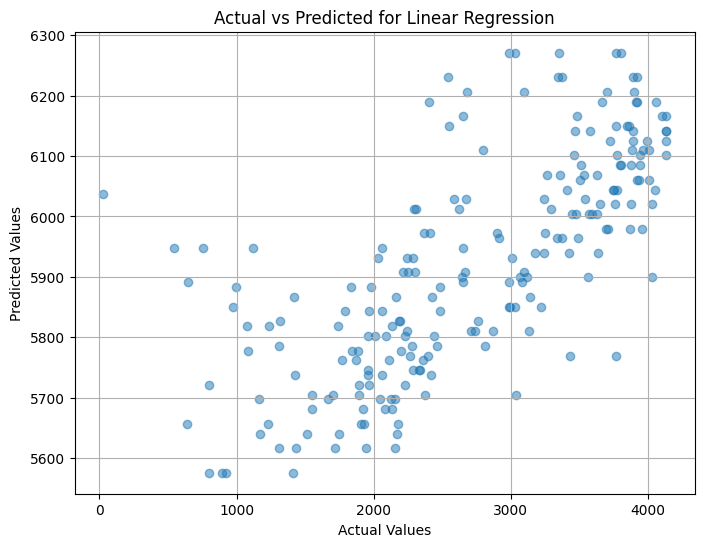

Training Random Forest...

Metrics for Random Forest:
  RMSE: 800.2321584522089
  MAE: 665.0708635672408
  R²: 0.29552629939485064


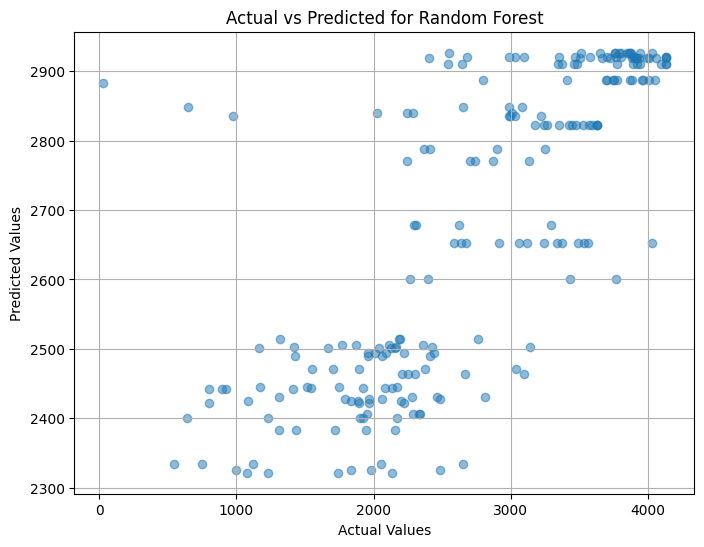

Training Gradient Boosting...

Metrics for Gradient Boosting:
  RMSE: 594.7978672091488
  MAE: 432.5353612898906
  R²: 0.6108011130386934


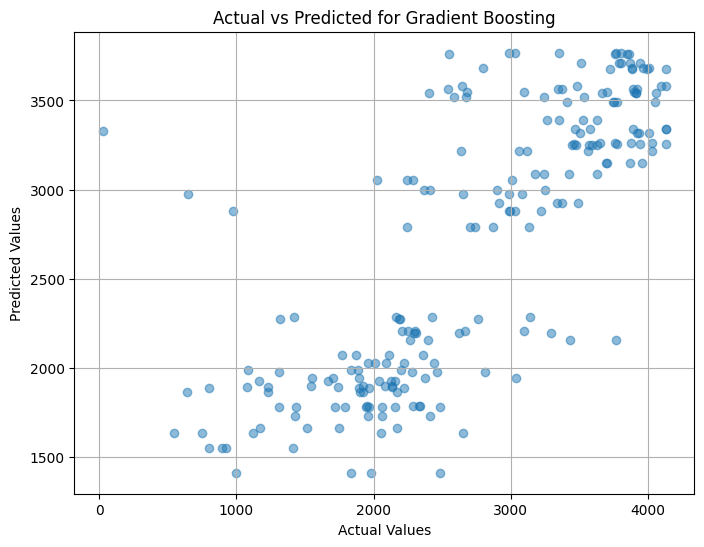

Training Decision Tree...

Metrics for Decision Tree:
  RMSE: 589.5996546585816
  MAE: 439.9505393642242
  R²: 0.6175741634482492


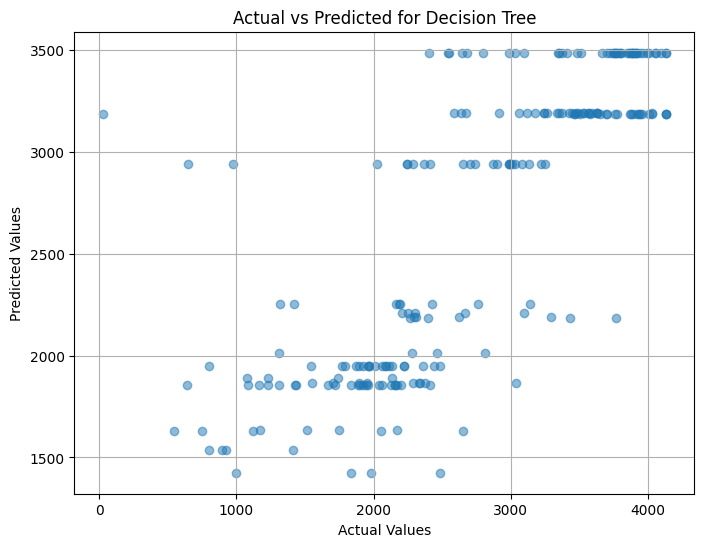

In [17]:
results = {}
best_model = None
best_rmse = float("inf")
best_model_name = None
best_model_params = None

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)
    
    evaluator_rmse = RegressionEvaluator(labelCol="num_rides", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="num_rides", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="num_rides", predictionCol="prediction", metricName="r2")
    
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    results[model_name] = {"rmse": rmse, "mae": mae, "r2": r2}

    print(f"\nMetrics for {model_name}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R²: {r2}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = trained_model
        best_model_name = model_name
        best_model_params = trained_model.extractParamMap()
    
    predictions_pd = predictions.select("num_rides", "prediction").toPandas()

    # Plot actual vs predicted values for this model
    plt.figure(figsize=(8, 6))
    plt.scatter(predictions_pd['num_rides'], predictions_pd['prediction'], alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

#### SAVING BEST MODEL

In [18]:
print(f"\nBest model: {best_model_name} with RMSE: {best_rmse}")

best_model_local = best_model


Best model: Decision Tree with RMSE: 589.5996546585816


### INFERENCE

In [19]:
from pyspark.sql.functions import col, dayofweek, month, year, avg, round

def predict_and_show_demand_grouped(model, scaler_model, new_data_path):
    spark = SparkSession.builder.appName("DemandForecastingInference").getOrCreate()

    # Load the new dataset for testing
    test_df = spark.read.csv(new_data_path, header=True, inferSchema=True)

    # Preprocess the new data
    if 'started_at' not in test_df.columns:
        raise ValueError("The test dataset must contain a 'started_at' column for time-based feature extraction.")
    
    test_df = test_df.withColumn("started_at", col("started_at").cast("timestamp"))
    
    test_df = test_df.withColumn("dayofweek", dayofweek(col("started_at"))) \
                     .withColumn("month", month(col("started_at"))) \
                     .withColumn("year", year(col("started_at")))

    # Feature engineering and scaling
    assembler = VectorAssembler(inputCols=["dayofweek", "month", "year"], outputCol="raw_features")
    test_df = assembler.transform(test_df)

    test_df = scaler_model.transform(test_df)

    # Make predictions
    predictions = model.transform(test_df)

    # Add predicted values to the dataframe
    predictions = predictions.withColumn("predicted_rides", col("prediction"))

    # Group by day of the week, month, and year, then calculate the average predicted rides
    grouped_predictions = predictions.groupBy("dayofweek", "month", "year") \
                                     .agg(avg("predicted_rides").alias("avg_predicted_rides"))

    # Round off the average predicted rides to 2 decimal places
    rounded_predictions = grouped_predictions.withColumn("avg_predicted_rides", round(col("avg_predicted_rides"), 2))

    # Show the grouped and rounded predictions DataFrame
    rounded_predictions.show(truncate=False)

    return rounded_predictions

In [ ]:
new_data_path = "D:/BDA_MINI_PROJECT/test_data.csv"
grouped_predictions_df = predict_and_show_demand_grouped(best_model_local, scaler_model, new_data_path)